# Muffin vs Chihuahua Classification using ResNet50

# #4 Exercise 6, Jullian Bilan & Kyla Elijah Ramiro
BSCS 3-A AI

This notebook trains a ResNet50 model to classify images as either muffins or chihuahuas.

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os

## Configuration

Set up the hyperparameters and directory paths for training.

In [16]:
# Define constants
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32
EPOCHS = 10
TRAIN_DIR = 'train'
TEST_DIR = 'test'
MODEL_SAVE_PATH = 'muffin_chihuahua_resnet50.h5'

## Data Preparation

Load training and test data with preprocessing and augmentation for better model generalization.

In [17]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only preprocessing for validation/test
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

print("Loading Training Data:")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

print("\nLoading Test Data:")
validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Loading Training Data:
Found 4733 images belonging to 2 classes.

Loading Test Data:
Found 1184 images belonging to 2 classes.


## Model Definition

Build the ResNet50 model with pre-trained ImageNet weights and add custom classification layers.

In [18]:
# Load pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Training

Train the model for 10 epochs with training and validation data.

In [19]:
# Let Keras automatically determine steps from the generator
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9774 - loss: 0.0593 - val_accuracy: 0.9890 - val_loss: 0.0238
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.9928 - loss: 0.0202 - val_accuracy: 0.9907 - val_loss: 0.0260
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.9945 - loss: 0.0142 - val_accuracy: 0.9958 - val_loss: 0.0186
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.9958 - loss: 0.0112 - val_accuracy: 0.9941 - val_loss: 0.0195
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.9985 - loss: 0.0057 - val_accuracy: 0.9941 - val_loss: 0.0212
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.9983 - loss: 0.0066 - val_accuracy: 0.9856 - val_loss: 0.0459
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.9987 - loss: 0.0047 - val_accuracy: 0.9941 - val_loss: 0.0179
Epoch 8/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9987 - loss: 0.0046 - val_accu

## Save Model

Save the trained model as an H5 file for later use.

In [20]:
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to muffin_chihuahua_resnet50.h5


## Model Performance Analysis

Let's visualize and analyze the training results to understand how well our model performed.


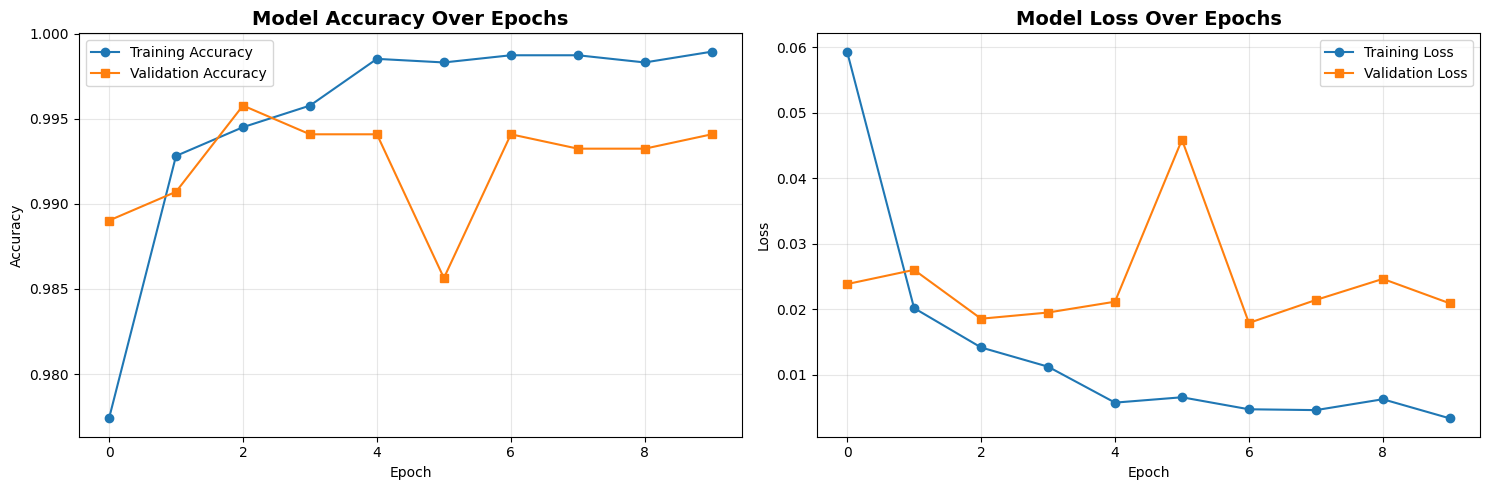

FINAL TRAINING METRICS
Final Training Accuracy: 0.9989 (99.89%)
Final Validation Accuracy: 0.9941 (99.41%)
Final Training Loss: 0.0033
Final Validation Loss: 0.0209


In [21]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("="*60)
print("FINAL TRAINING METRICS")
print("="*60)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f} ({history.history['accuracy'][-1]*100:.2f}%)")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f} ({history.history['val_accuracy'][-1]*100:.2f}%)")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print("="*60)


## Detailed Model Evaluation

Now let's evaluate the model on the test set and generate a comprehensive performance report including confusion matrix, classification metrics, and sample predictions.


Generating predictions on test set...
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 921ms/step


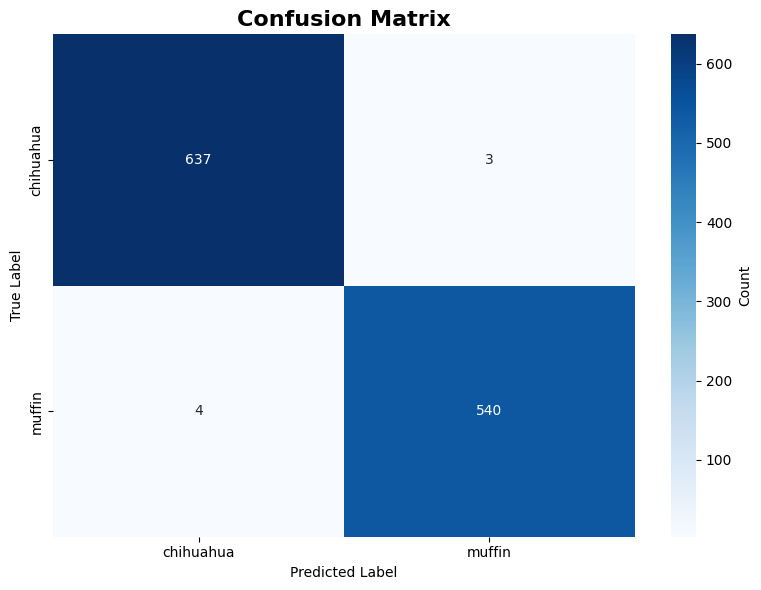


CLASSIFICATION REPORT
              precision    recall  f1-score   support

   chihuahua     0.9938    0.9953    0.9945       640
      muffin     0.9945    0.9926    0.9936       544

    accuracy                         0.9941      1184
   macro avg     0.9941    0.9940    0.9940      1184
weighted avg     0.9941    0.9941    0.9941      1184

DETAILED METRICS SUMMARY
Overall Accuracy:  0.9941 (99.41%)
Precision:         0.9945
Recall:            0.9926
F1-Score:          0.9936


In [22]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np

# Reset the test generator
validation_generator.reset()

# Get predictions
print("Generating predictions on test set...")
y_pred_proba = model.predict(validation_generator, steps=len(validation_generator))
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
y_true = validation_generator.classes

# Get class names
class_names = list(validation_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("="*60)
print("DETAILED METRICS SUMMARY")
print("="*60)
print(f"Overall Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision:         {precision:.4f}")
print(f"Recall:            {recall:.4f}")
print(f"F1-Score:          {f1:.4f}")
print("="*60)


## ROC Curve and AUC Score

The ROC (Receiver Operating Characteristic) curve shows the trade-off between true positive rate and false positive rate. AUC (Area Under Curve) measures the overall performance - closer to 1.0 is better.


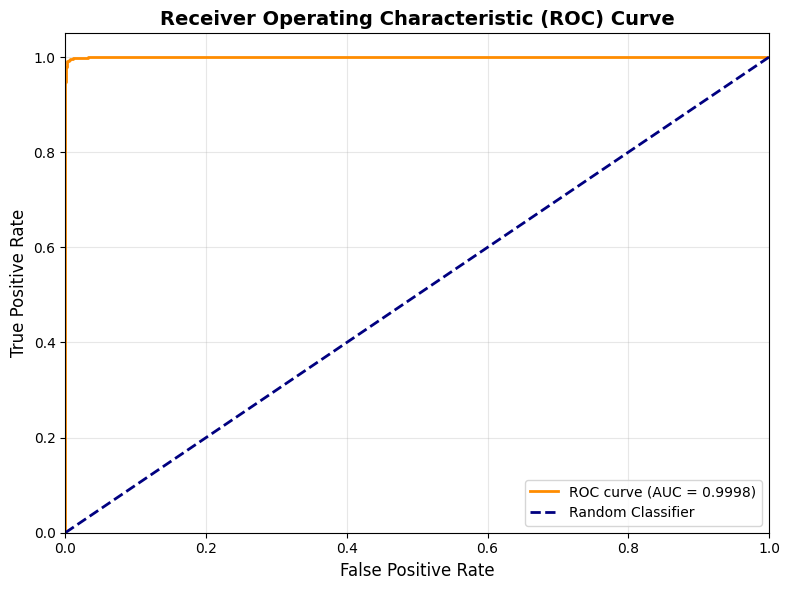


AUC Score: 0.9998
Excellent performance! 🎉


In [23]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAUC Score: {roc_auc:.4f}")
if roc_auc > 0.9:
    print("Excellent performance! 🎉")
elif roc_auc > 0.8:
    print("Good performance! 👍")
elif roc_auc > 0.7:
    print("Fair performance. Consider more training or data.")
else:
    print("Poor performance. Model needs improvement.")


## Sample Predictions Visualization

Let's visualize some random predictions from the test set to see how the model performs on individual images.


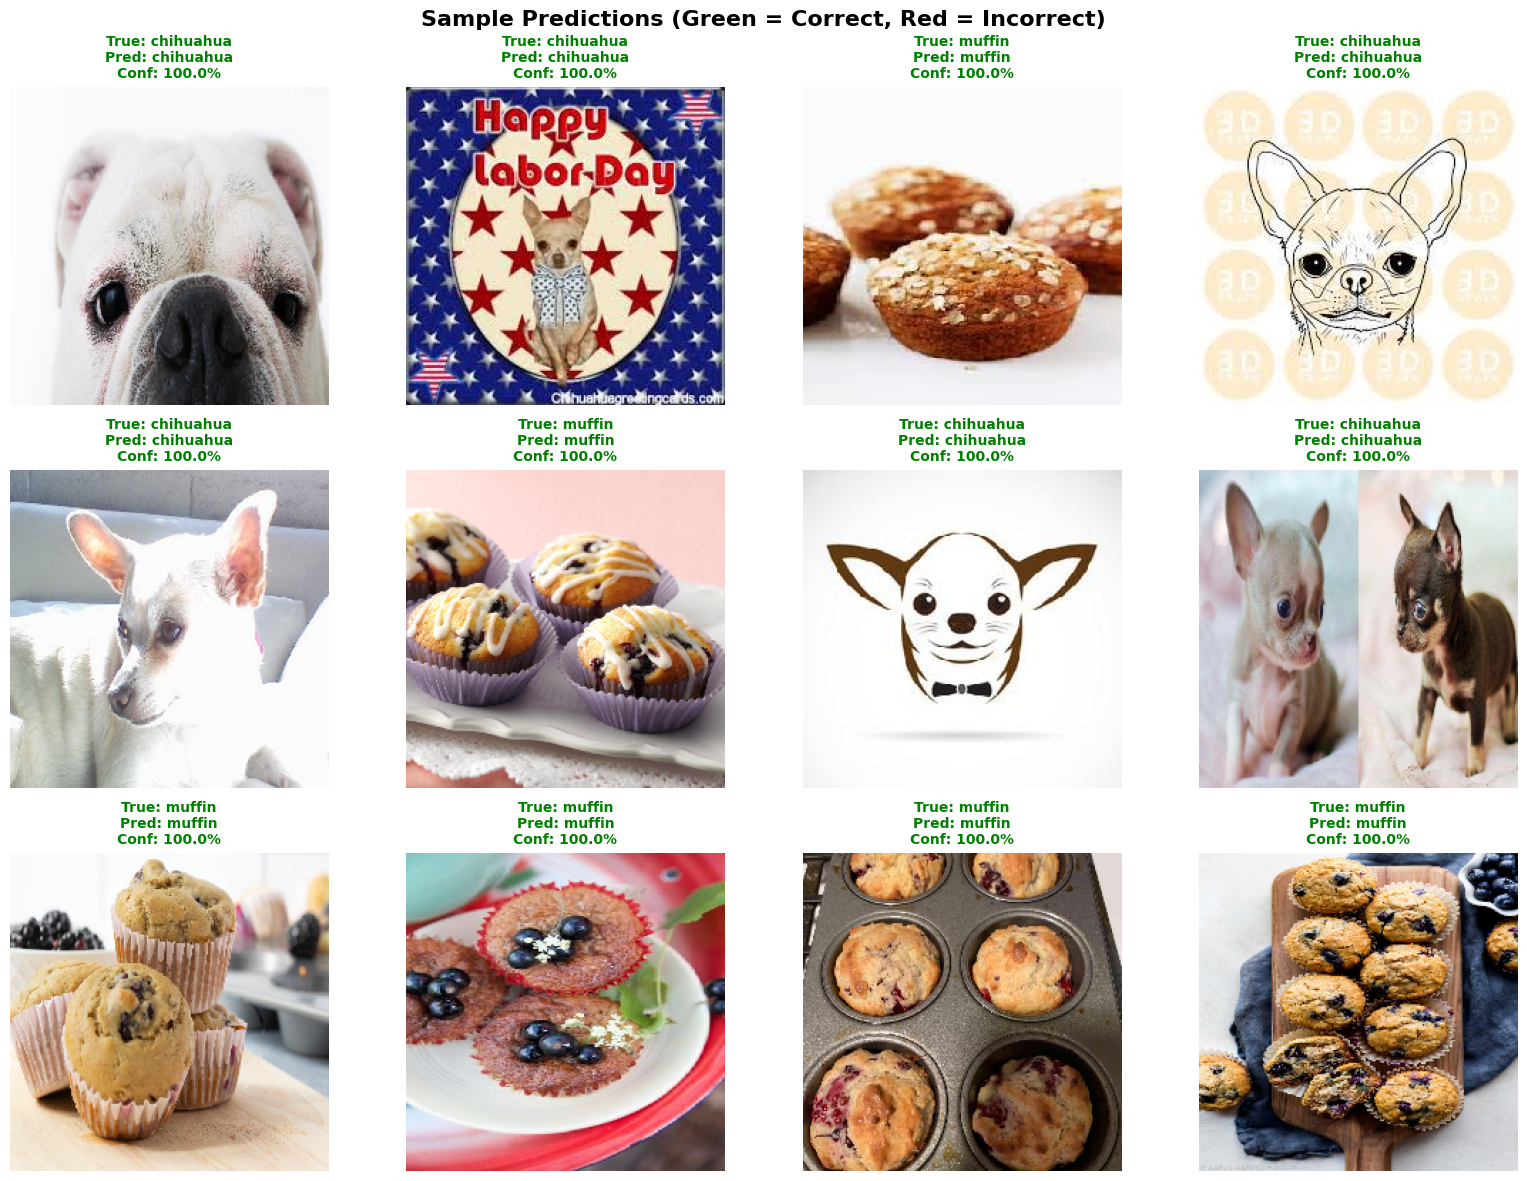

In [24]:
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Get random sample predictions
validation_generator.reset()
num_samples = 12

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

# Get some random indices
total_samples = len(validation_generator.filenames)
sample_indices = random.sample(range(total_samples), num_samples)

for idx, sample_idx in enumerate(sample_indices):
    # Load image
    img_path = validation_generator.directory + '/' + validation_generator.filenames[sample_idx]
    img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Predict
    pred_proba = model.predict(img_array, verbose=0)[0][0]
    true_label = validation_generator.classes[sample_idx]
    
    # Determine predicted class
    pred_class = 1 if pred_proba > 0.5 else 0
    confidence = pred_proba if pred_proba > 0.5 else 1 - pred_proba
    
    # Get class names
    pred_name = class_names[pred_class]
    true_name = class_names[true_label]
    
    # Determine if correct
    is_correct = pred_class == true_label
    color = 'green' if is_correct else 'red'
    
    # Plot
    axes[idx].imshow(img)
    axes[idx].axis('off')
    title = f'True: {true_name}\nPred: {pred_name}\nConf: {confidence*100:.1f}%'
    axes[idx].set_title(title, color=color, fontsize=10, fontweight='bold')

plt.suptitle('Sample Predictions (Green = Correct, Red = Incorrect)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


## Per-Class Performance Analysis

Let's break down the performance metrics for each class to identify if the model is biased towards one class.



PER-CLASS PERFORMANCE SUMMARY
    Class  Total Samples  Correct Predictions  Incorrect Predictions  Precision   Recall  F1-Score
chihuahua            640                  637                      3   0.993760 0.995313  0.994536
   muffin            544                  540                      4   0.994475 0.992647  0.993560


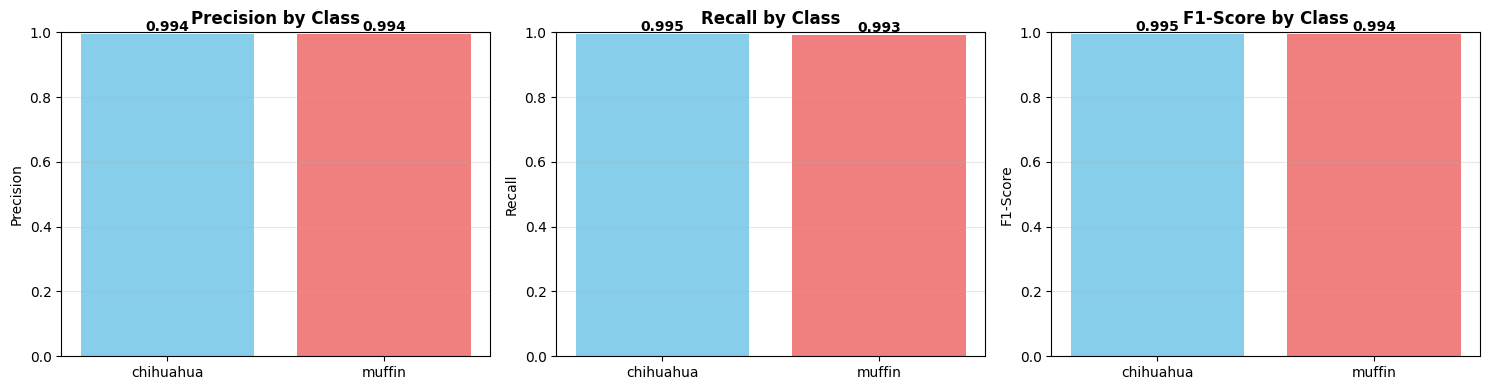

In [25]:
import pandas as pd

# Calculate per-class metrics
tn, fp, fn, tp = cm.ravel()

# Metrics for class 0 (typically chihuahua)
class_0_precision = tn / (tn + fn) if (tn + fn) > 0 else 0
class_0_recall = tn / (tn + fp) if (tn + fp) > 0 else 0
class_0_f1 = 2 * (class_0_precision * class_0_recall) / (class_0_precision + class_0_recall) if (class_0_precision + class_0_recall) > 0 else 0

# Metrics for class 1 (typically muffin)
class_1_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
class_1_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
class_1_f1 = 2 * (class_1_precision * class_1_recall) / (class_1_precision + class_1_recall) if (class_1_precision + class_1_recall) > 0 else 0

# Create a summary table
summary_data = {
    'Class': class_names,
    'Total Samples': [tn + fp, tp + fn],
    'Correct Predictions': [tn, tp],
    'Incorrect Predictions': [fp, fn],
    'Precision': [class_0_precision, class_1_precision],
    'Recall': [class_0_recall, class_1_recall],
    'F1-Score': [class_0_f1, class_1_f1]
}

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("PER-CLASS PERFORMANCE SUMMARY")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)

# Visualize per-class metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    values = df_summary[metric].values
    bars = axes[idx].bar(class_names, values, color=['skyblue', 'lightcoral'])
    axes[idx].set_title(f'{metric} by Class', fontsize=12, fontweight='bold')
    axes[idx].set_ylim([0, 1])
    axes[idx].set_ylabel(metric)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.3f}',
                      ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


## Test Your Own Image

Upload or specify the path to your own image to test the model!


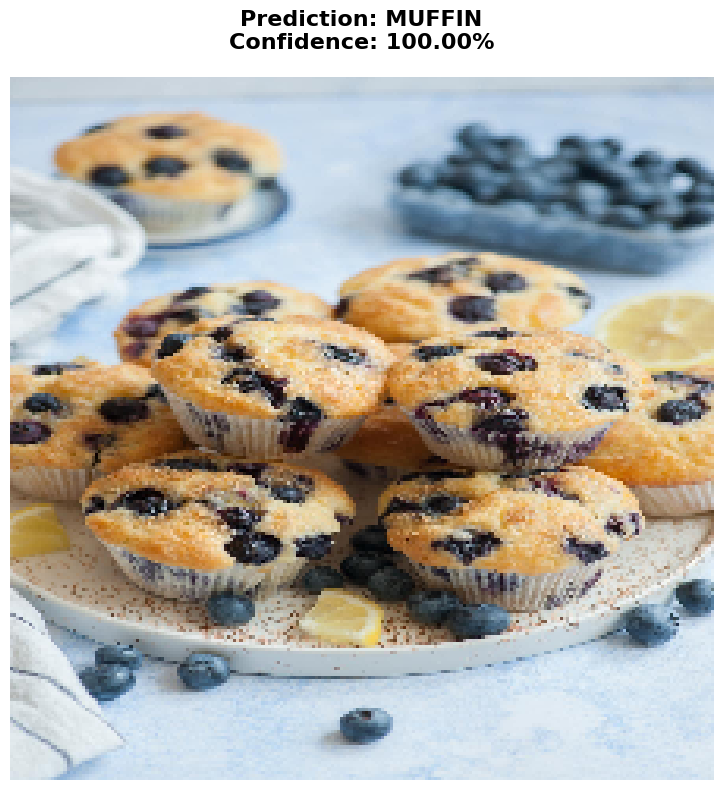

Predicted Class: MUFFIN
Confidence: 100.00%
Raw Probability Score: 1.0000


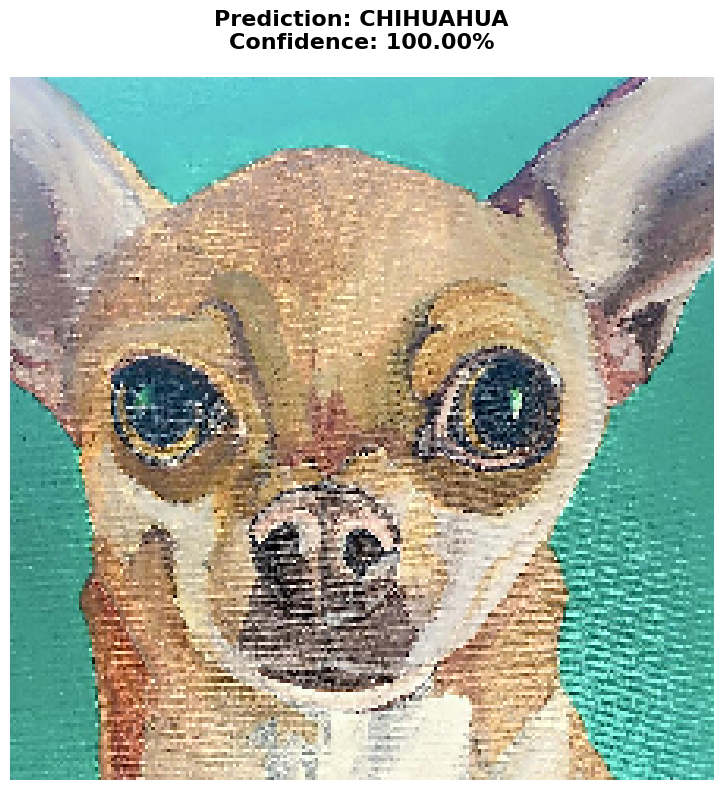

Predicted Class: CHIHUAHUA
Confidence: 100.00%
Raw Probability Score: 0.0000


('chihuahua', np.float32(100.0))

In [34]:
def predict_image(img_path):
    """
    Predict whether an image is a muffin or chihuahua
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Make prediction
    prediction = model.predict(img_array, verbose=0)
    probability = prediction[0][0]
    
    # Get class names
    class_names_list = list(train_generator.class_indices.keys())
    
    # Determine the predicted class
    if probability > 0.5:
        predicted_class = class_names_list[1]
        confidence = probability * 100
    else:
        predicted_class = class_names_list[0]
        confidence = (1 - probability) * 100
    
    # Display the image with prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {predicted_class.upper()}\nConfidence: {confidence:.2f}%', 
              fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print("="*50)
    print(f"Predicted Class: {predicted_class.upper()}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Raw Probability Score: {probability:.4f}")
    print("="*50)
    
    return predicted_class, confidence

# Test with your own image
# Replace with your image path
# Example: image_path = 'test/chihuahua/image1.jpg'
predict_image('test\muffin\img_0_10.jpg')
predict_image('test\chihuahua\img_0_72.jpg')

